In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

## 1. Обучаем простенькую сверточную нейронку

In [2]:
transform = T.ToTensor()
train_set = CIFAR10('CIFAR10', train=True, download=True,
                    transform=transform)
test_set = CIFAR10('CIFAR10', train=False, download=True,
                   transform=transform)
len(train_set), len(test_set)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [3]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Class: horse


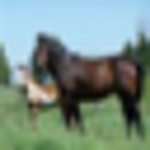

In [4]:
item = 12
print(f'Class: {train_set.classes[train_set[item][1]]}')
T.ToPILImage()(train_set[item][0]).resize((150, 150))

In [5]:
train_loader = DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, pin_memory=True, num_workers=4)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
from torch import nn

class ConvNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
        )
        
        self.head = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, images):
        features = self.features(images)
        features = features.mean(dim=(2, 3))
        logits = self.head(features)
        return logits

In [8]:
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [9]:
for images, labels in train_loader:
    break

In [10]:
with torch.no_grad():
    images = images.to(device)
    logits = model(images)
logits.shape

torch.Size([32, 10])

In [11]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

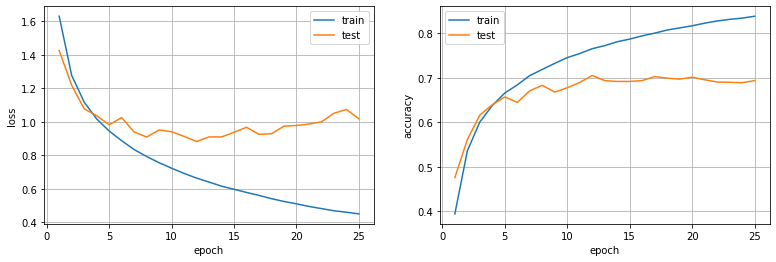

Best test accuracy: 0.7053


In [12]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')

## 2. Добавляем аугментации

In [13]:
def get_cifar10_transform(size, train=True):
    if train:
        transform = T.Compose([
            T.RandomCrop(size, padding=4),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    else:
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    return transform

In [14]:
train_set = CIFAR10('CIFAR10', train=True, download=True,
                    transform=get_cifar10_transform(32, train=True))
test_set = CIFAR10('CIFAR10', train=False, download=True,
                   transform=get_cifar10_transform(32, train=False))
len(train_set), len(test_set)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

Class: horse


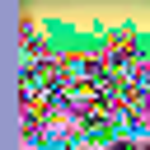

In [15]:
item = 12
print(f'Class: {train_set.classes[train_set[item][1]]}')
T.ToPILImage()(train_set[item][0]).resize((150, 150))

In [16]:
train_loader = DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, pin_memory=True, num_workers=4)

In [17]:
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

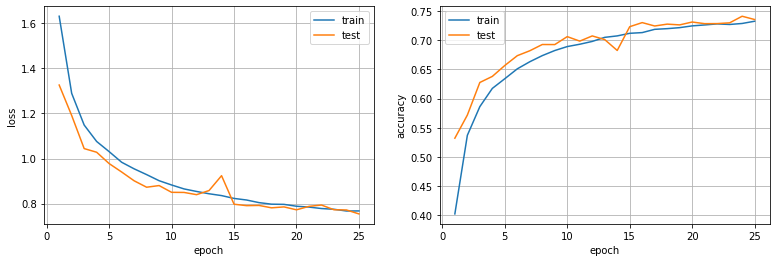

Best test accuracy: 0.741


In [18]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')

## 3. Пробуем архитектуру из torchvision

[Данные](https://www.kaggle.com/lantian773030/pokemonclassification)

In [ ]:
%%bash
kaggle datasets download -d lantian773030/pokemonclassification
unzip -qq pokemonclassification.zip

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

classes = os.listdir('PokemonData')
os.mkdir('PokemonData/train/')
os.mkdir('PokemonData/test/')

for class_name in classes:
    os.mkdir(f'PokemonData/train/{class_name}')
    os.mkdir(f'PokemonData/test/{class_name}')

    objects = os.listdir(f'PokemonData/{class_name}')
    train_objects, test_objects = train_test_split(objects, test_size=0.2)
    
    for object_name in train_objects:
        os.rename(f'PokemonData/{class_name}/{object_name}',
                  f'PokemonData/train/{class_name}/{object_name}')
    
    for object_name in test_objects:
        os.rename(f'PokemonData/{class_name}/{object_name}',
                  f'PokemonData/test/{class_name}/{object_name}')
    
    shutil.rmtree(f'PokemonData/{class_name}')

In [3]:
from torchvision.datasets import ImageFolder

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

train_set = ImageFolder('PokemonData/train/', transform=train_transform)
test_set = ImageFolder('PokemonData/test/', transform=test_transform)
len(train_set), len(test_set)

(5392, 1428)

Golbat


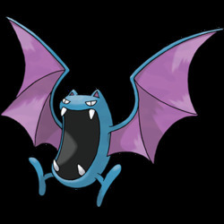

In [4]:
item = 1445
print(train_set.classes[train_set[item][1]])
T.ToPILImage()(train_set[item][0])

In [5]:
num_classes = len(train_set.classes)
print('Число классов:', num_classes)

Число классов: 150


In [6]:
train_loader = DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, pin_memory=True, num_workers=4)

In [12]:
from torchvision.models import resnet18

model = resnet18(pretrained=False, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
model

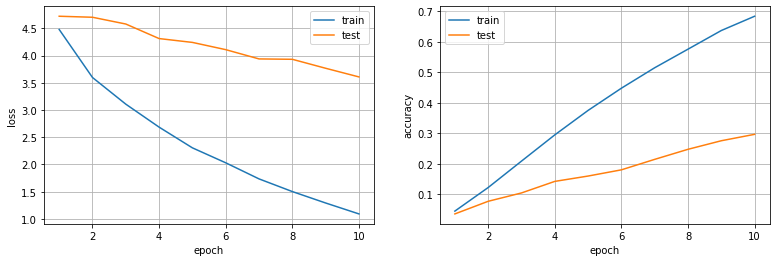

Best test accuracy: 0.2969187675070028


In [13]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')

## 4. Файн-тюним

In [14]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_set = ImageFolder('PokemonData/train/', transform=train_transform)
test_set = ImageFolder('PokemonData/test/', transform=test_transform)
len(train_set), len(test_set)

(5392, 1428)

In [15]:
train_loader = DataLoader(train_set, batch_size=32, pin_memory=True, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, pin_memory=True, num_workers=4)

In [16]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 150)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

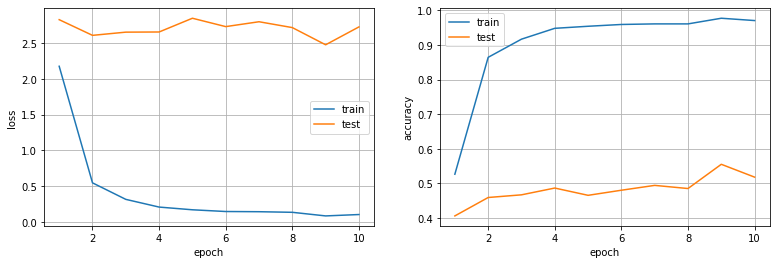

Best test accuracy: 0.5553221288515406


In [17]:
new_train_losses, new_test_losses = [], []
new_train_accuracies, new_test_accuracies = [], []
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    new_train_losses += [running_loss / len(train_loader.dataset)]
    new_train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    new_test_losses += [running_loss / len(test_loader.dataset)]
    new_test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(new_train_losses, new_test_losses, new_train_accuracies, new_test_accuracies)

print(f'Best test accuracy: {max(new_test_accuracies)}')

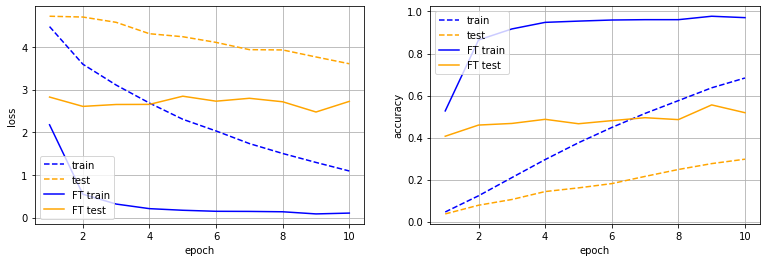

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='blue', linestyle='--')
axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='orange', linestyle='--')
axs[0].plot(range(1, len(new_train_losses) + 1), new_train_losses, label='FT train', color='blue')
axs[0].plot(range(1, len(new_test_losses) + 1), new_test_losses, label='FT test', color='orange')
axs[0].set_ylabel('loss')

axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train', color='blue', linestyle='--')
axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test', color='orange', linestyle='--')
axs[1].plot(range(1, len(new_train_accuracies) + 1), new_train_accuracies, color='blue', label='FT train')
axs[1].plot(range(1, len(new_test_accuracies) + 1), new_test_accuracies, color='orange', label='FT test')
axs[1].set_ylabel('accuracy')

for ax in axs:
    ax.grid()
    ax.set_xlabel('epoch')
    ax.legend()

plt.show()